# Neural Network- Confusion Matrix


In [142]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Loading the dataset

In [197]:
# Read in the dataset
pd.set_option('display.max_columns', 50)
df = pd.read_csv('shortenedorbit.csv', low_memory=False)
#df = df.drop(columns=df.columns[0], axis=1)
df = df.drop(['Name', 'Arc_years', 'Number','Computer', 'Last_obs', 'Principal_desig',
              'Other_desigs','Ref', 'Hex_flags', 'U'],axis='columns')

df['Perturbers'] = df['Perturbers'].fillna('No_Coarse')
df['Perturbers_2'] = df['Perturbers_2'].fillna('No_Precise')

df = df.drop(df[df['Orbit_type'] == 'MBA'].sample(frac=.65).index)

possibleLabels = df.Orbit_type.value_counts()
labeldummies = pd.get_dummies(df.Orbit_type)
pert1dummies = pd.get_dummies(df.Perturbers)
pert2dummies = pd.get_dummies(df.Perturbers_2)
df = pd.concat([pert1dummies,pert2dummies,df],axis='columns')

df = df.drop(['Perturbers'],axis='columns')
df = df.drop(['Perturbers_2'],axis='columns')
df = df.fillna(0)
df.head()

,M-h,M-v,No_Coarse,38h,3Eh,3Ek,No_Precise,NEO_flag,One_km_NEO_flag,PHA_flag,H,G,Num_obs,rms,Epoch,M,Peri,Node,i,e,n,a,Num_opps,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type
2,0,1,0,1,0,0,0,0.0,0.0,0.0,16.80,0.15,171.0,0.32,2459200.5,14.03074,202.06597,152.13493,14.20004,0.221219,0.215091,2.758806,10,2.459135e+06,4.582282,2.148507,3.369106,1.311898,1.279152,MBA
7,0,1,0,0,0,1,0,0.0,0.0,0.0,14.19,0.15,1161.0,0.54,2459200.5,231.94039,139.18996,285.60788,0.78627,0.132331,0.176895,3.142861,18,2.459924e+06,5.571701,2.726962,3.558760,1.543912,1.218737,MBA
10,1,0,0,0,1,0,0,1.0,1.0,0.0,17.40,0.15,153.0,0.48,2459200.5,264.84645,215.06158,308.95155,36.64391,0.907512,0.299142,2.214205,4,2.459519e+06,3.294783,0.204789,4.223622,0.195318,1.435771,Apollo
11,0,1,0,0,0,1,0,0.0,0.0,0.0,15.13,0.15,646.0,0.51,2459200.5,222.56184,154.90886,248.17847,8.93968,0.101412,0.196968,2.925541,16,2.459898e+06,5.003908,2.628857,3.222225,1.447727,1.249756,MBA
13,0,1,0,1,0,0,0,0.0,0.0,0.0,18.70,0.15,95.0,0.24,2459200.5,267.56485,6.17458,165.07979,1.62649,0.135050,0.259581,2.433817,5,2.459557e+06,3.796925,2.105130,2.762505,1.194714,1.357536,MBA


## Preprocessing

### Splitting the data, scaling the data, and label encoding

In [198]:
le = preprocessing.LabelEncoder()
y_cm = np.unique(df['Orbit_type'])
y = df['Orbit_type']
y = le.fit_transform(y)

np.unique(y)
df = df.drop(['Orbit_type'],axis='columns')

In [199]:
X = df.iloc[:,:40].values
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [200]:
print("Shapes of data")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes of data
X_train: (777, 29)
y_train: (777,)
X_test: (259, 29)
y_test: (259,)


## Neural Network

### Logistics, Relu, Tanh Activation Functions

In [201]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]
kf = KFold(n_splits=10)

NN_Logistics_confmatrix = []
NN_Relu_confmatrix = []
NN_Tanh_confmatrix = []

NN_Logistics_avg_confmatrix = np.zeros((10,10))
NN_Relu_avg_confmatrix = np.zeros((10,10))
NN_Tanh_avg_confmatrix = np.zeros((10,10))

In [215]:
def NN_conf(cval1, cval2, cval3):
    NN_Logistics = MLPClassifier(max_iter=cval1,hidden_layer_sizes=(50,), activation='logistic', solver='adam')
    NN_Relu = MLPClassifier(max_iter=cval2,hidden_layer_sizes=(50,), activation='relu', solver='adam')
    NN_Tanh = MLPClassifier(max_iter=cval3,hidden_layer_sizes=(50,), activation='tanh', solver='adam')
    
    for train, test in kf.split(X_train):
        X_tr = X_train[train,:]
        y_tr = y_train[train]
        X_ts = X_train[test,:]
        y_ts = y_train[test]
        
        X_tr = preprocessing.scale(X_tr)
        X_ts = preprocessing.scale(X_ts)
        
        sm = SMOTE(k_neighbors=3)
        X_tr_smt, y_tr_smt = sm.fit_resample(X_tr, y_tr)
        
        # Logistics
        NN_Logistics.fit(X_tr_smt,y_tr_smt)
        NN_Logistics_yhat_test = NN_Logistics.predict(X_ts) 
        
        # Relu
        NN_Relu.fit(X_tr_smt,y_tr_smt)
        NN_Relu_yhat_test = NN_Relu.predict(X_ts) 
        
        # Tanh
        NN_Tanh.fit(X_tr_smt,y_tr_smt)
        NN_Tanh_yhat_test = NN_Tanh.predict(X_ts) 
        
        NN_Logistics_confmatrix.append(np.resize(confusion_matrix(y_ts, NN_Logistics_yhat_test),(10,10)))
        NN_Relu_confmatrix.append(np.resize(confusion_matrix(y_ts, NN_Relu_yhat_test),(10,10)))
        NN_Tanh_confmatrix.append(np.resize(confusion_matrix(y_ts, NN_Tanh_yhat_test),(10,10)))

In [216]:
NN_conf(100, 100, 100)

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\

In [217]:
for (mat, mat2, mat3) in zip(NN_Logistics_confmatrix, NN_Relu_confmatrix, NN_Tanh_confmatrix):
    NN_Logistics_avg_confmatrix = NN_Logistics_avg_confmatrix + mat
    NN_Relu_avg_confmatrix = NN_Relu_avg_confmatrix + mat2
    NN_Tanh_avg_confmatrix = NN_Tanh_avg_confmatrix + mat3

NN_Logistics_avg_confmatrix = NN_Logistics_avg_confmatrix / 9
NN_Relu_avg_confmatrix = NN_Relu_avg_confmatrix / 9
NN_Tanh_avg_confmatrix = NN_Tanh_avg_confmatrix / 9

In [218]:
NN_Logistics_avg_confmatrix

array([[ 5.28257888,  0.82990398,  0.37311385,  0.        ,  0.        ,
         0.        ,  0.        ,  0.7037037 ,  0.35802469,  1.67215364],
       [ 2.14677641,  1.68587106,  0.59533608,  0.        ,  0.        ,
         0.        ,  0.7037037 ,  0.12345679,  1.21399177,  0.        ],
       [ 0.24965706,  0.35939643,  0.59396433,  0.        ,  0.        ,
         0.11111111,  0.        ,  0.48422497,  0.73251029,  0.7037037 ],
       [ 0.82853224,  0.        ,  0.        ,  1.20438957,  0.12345679,
         0.        ,  3.08093278,  0.        ,  0.        ,  0.        ],
       [ 3.56790123,  0.        ,  0.74897119,  0.73113855,  2.43621399,
        18.09876543,  1.70233196,  1.9218107 ,  0.        ,  0.        ],
       [ 1.17558299,  0.12482853,  0.2345679 ,  0.4691358 , 13.96570645,
         7.94924554,  0.4691358 ,  6.09053498,  0.37174211,  8.30178326],
       [30.91495199,  2.75308642,  2.96021948,  0.96844993,  1.29766804,
         0.12482853,  3.58161866,  0.35802469

## CONFUSION MATRICES 

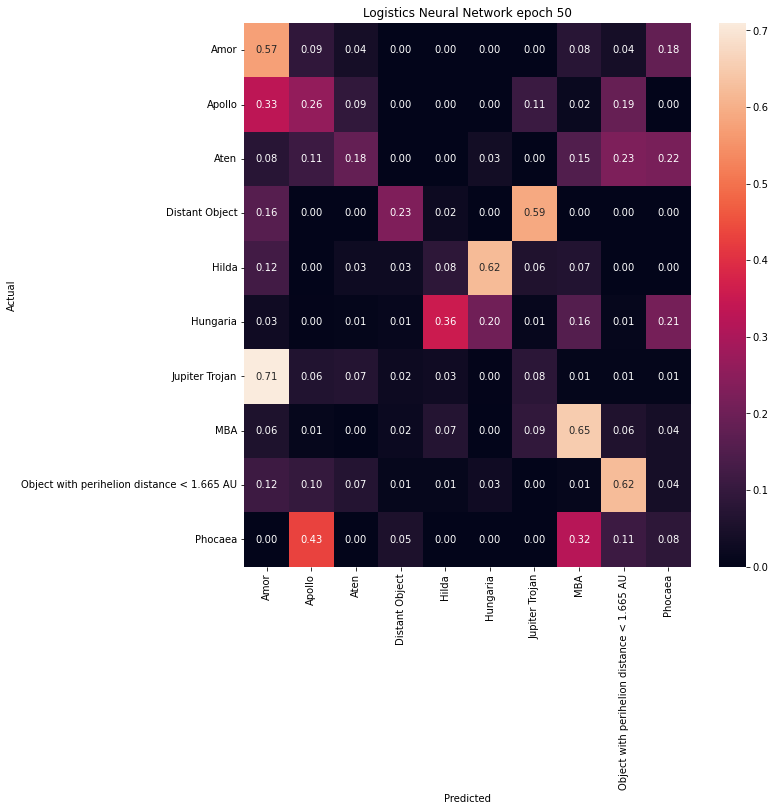

In [219]:
# Normalise
Logisticscmn = NN_Logistics_avg_confmatrix.astype('float') / NN_Logistics_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(Logisticscmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.title("Logistics Neural Network epoch 50") 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Logistics Neural Network Confusion Matrix')
plt.show(block=False)

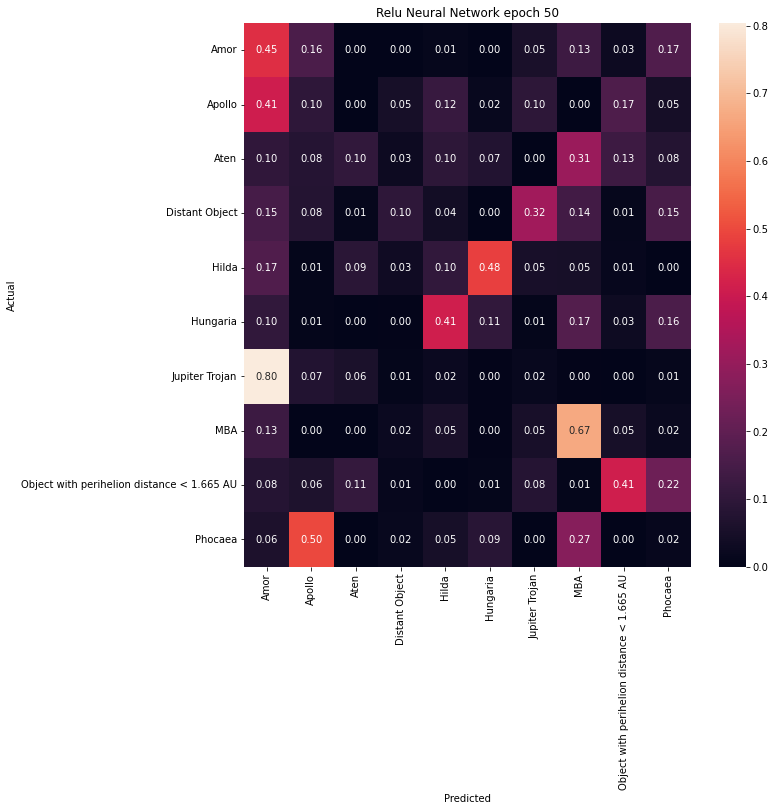

In [220]:
relucmn = NN_Relu_avg_confmatrix.astype('float') / NN_Relu_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(relucmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Relu Neural Network epoch 50") 
plt.savefig('Relu Neural Network Confusion Matrix')
plt.show(block=False)

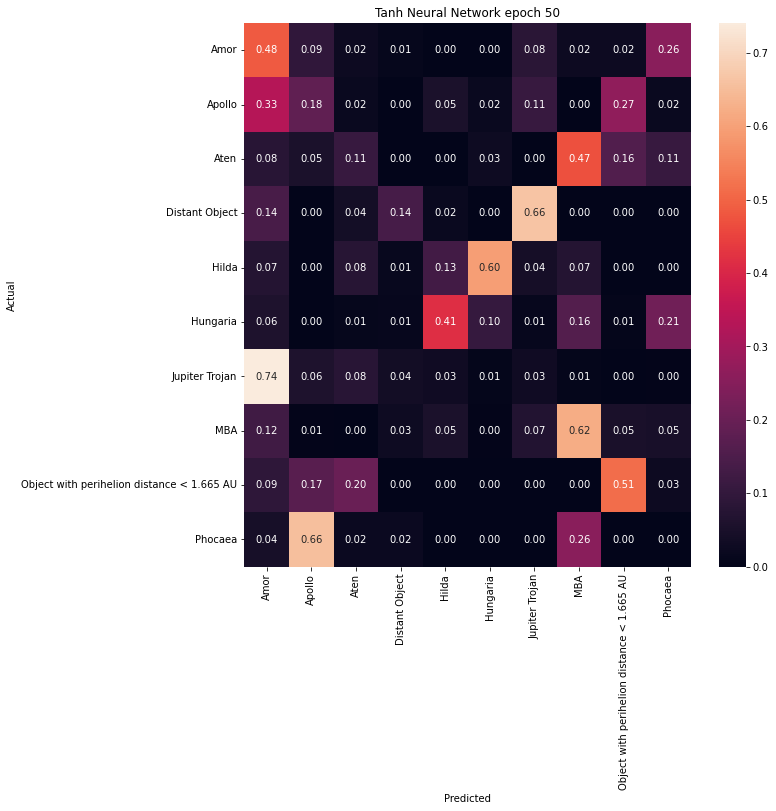

In [221]:
tanhcmn = NN_Tanh_avg_confmatrix.astype('float') / NN_Tanh_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(tanhcmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Tanh Neural Network epoch 50") 
plt.savefig('Tanh Neural Network Confusion Matrix')
plt.show(block=False)